## Imports for Data Extraction and Preprocessing

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import ijson
import logging
import numpy as np
import seaborn as sns

In [10]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Parse Data and create DataFrame

In [11]:
def parse_json(file_path, num_events):
    """
    parses the json file and returns a list of events

    :param file_path: path to the json file
    :param num_events: number of events that should be parsed
    """
    with open(file_path, 'rb') as f:
        events = ijson.items(f, 'item')
        limited_events = [next(events) for _ in range(num_events)]
        logger.info('All events parsed. Total number of events: {}'.format(len(limited_events)))
        return limited_events

# specify the number of events that should be preprocessed, max number of events is 264395
num_events = 264395
events = parse_json('stuttgart_events.json', num_events)

# Handle the nested structure of the original json file
events_df = pd.DataFrame(events)
all_keys = set().union(*events_df["eventData"].apply(lambda x: x.keys()))
for key in all_keys:
    events_df[key] = events_df["eventData"].apply(lambda x: x.get(key, None))

keys_location = set().union(*events_df["location"].apply(lambda x: x.keys()))
for key in keys_location:
    events_df[f'location.{key}'] = events_df["location"].apply(lambda x: x.get(key, None))

keys_location_location = set().union(*events_df["location.location"].apply(lambda x: x.keys()))
for key in keys_location_location:
    events_df[f'location.location.{key}'] = events_df["location.location"].apply(lambda x: x.get(key, None))

keys_location_location_address = set().union(*events_df["location.location.address"].apply(lambda x: x.keys()))
for key in keys_location_location_address:
    events_df[f'location.location.address.{key}'] = events_df["location.location.address"].apply(lambda x: x.get(key, None))

INFO:__main__:All events parsed. Total number of events: 264395


## Data Cleaning

In [12]:
# delete dictionary columns
events_df = events_df.drop('eventData', axis=1)
events_df = events_df.drop('location', axis=1)
events_df = events_df.drop('location.location', axis=1)
events_df = events_df.drop('location.location.address', axis=1)

# Only keep events that were not cancelled
events_df = events_df[events_df['cancelled'] == False]

# Only keep events where the location is actually in Stuttgart
events_df = events_df[events_df['location.location.address.city'] == 'Stuttgart']

## Visualize missing values

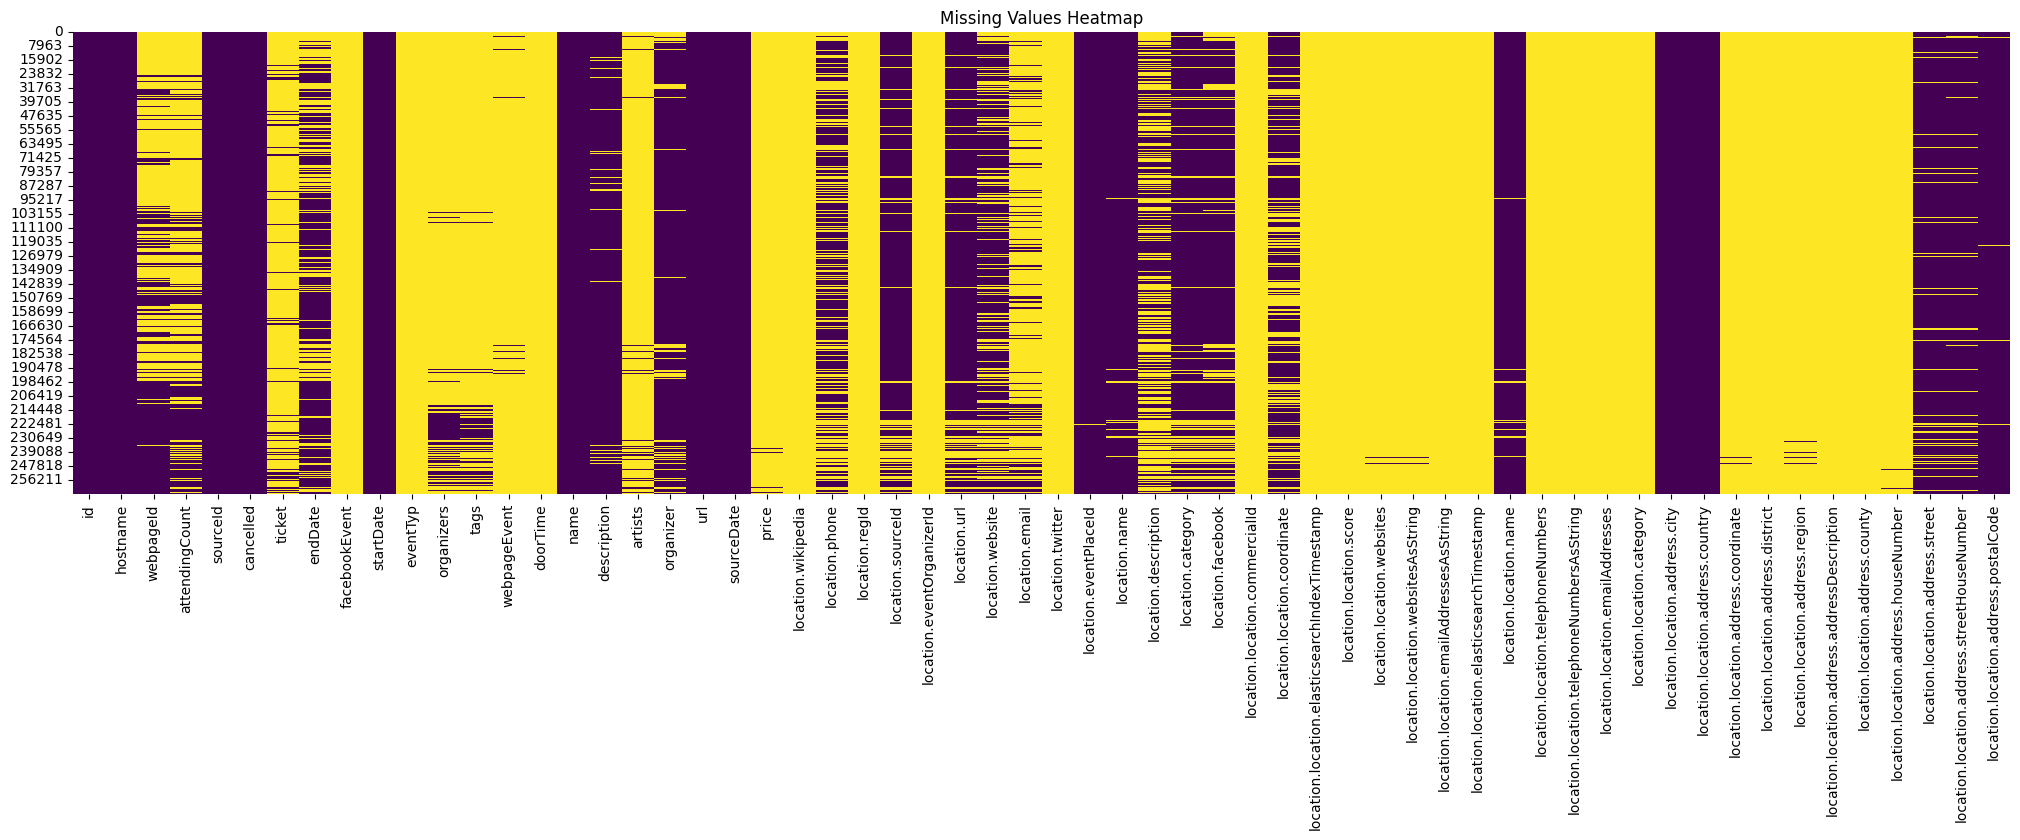

INFO:root:Shape of the DataFrame after dropping columns with more than 80% missing values: (261664, 30)


In [15]:
#Create a heatmap of missing values
plt.figure(figsize=(25, 6))  # Adjust the figure size as needed
sns.heatmap(events_df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

INFO:root:Shape of the DataFrame after dropping columns with more than 80% missing values: (261664, 30)


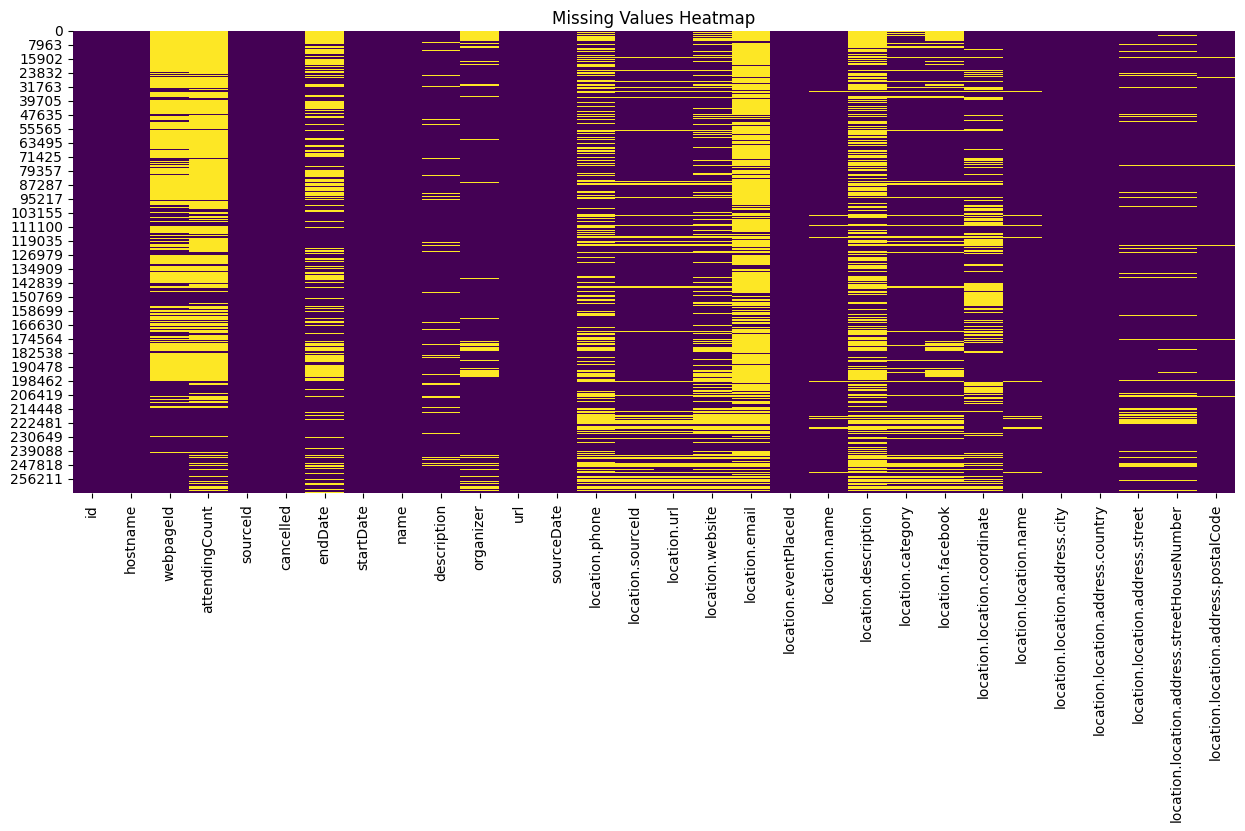

In [16]:
# drop columns with more than 80% missing values
events_df = events_df.dropna(thresh=events_df.shape[0]*0.2, axis=1)
logging.info('Shape of the DataFrame after dropping columns with more than 80% missing values: {}'.format(events_df.shape))
# again plot missing values after cleaning
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
sns.heatmap(events_df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

## Feature Engineering

### Create Feature "dayofweek" and only consider Wednesdays

In [ ]:
if 'startDate' in events_df.columns and events_df['startDate'].dtype != 'datetime64[ns]':
    events_df['startDate'] = pd.to_datetime(events_df['startDate'], format='mixed', utc=True)

# add column for day of week
events_df['dayofweek'] = events_df['startDate'].dt.dayofweek
# only consider events on Wednesdays
events_df = events_df[events_df['dayofweek'] == 2]
events_df.reset_index(drop=True, inplace=True)
# log the number of events remaining
logging.info('Number of events after filtering for Wednesdays: {}'.format(events_df.shape[0]))

### Continue with a sample of the data
### NOTE: When the whole dataset of Wednesdays should be used then comment out the following 3 lines

In [ ]:
# sample the data to reduce the number of events, e.g. only select 2000 events
events_df = events_df.sample(n=2000, random_state=42)
events_df.reset_index(drop=True, inplace=True)
logging.info('Number of events after sampling: {}'.format(events_df.shape[0]))

## Derive further time features from the startDate column

In [ ]:
# Create year column
events_df['year'] = events_df['startDate'].dt.year
# Create month column
events_df['month'] = events_df['startDate'].dt.month
# Create column with startHour
events_df['starting_hour'] = events_df['startDate'].apply(lambda x: x.hour)

## Extract the season from startDate

In [ ]:
# create a function to determine the season
def get_season(date: pd.Timestamp) -> str:
    """
    returns the season of a given date
    :param date: date for which the season should be determined
    :return: season of the given date
    """
    # spring
    if date.month >= 3 and date.month <= 5:
        return 'spring'
    # summer
    elif date.month >= 6 and date.month <= 8:
        return 'summer'
    # autumn
    elif date.month >= 9 and date.month <= 11:
        return 'autumn'
    # winter
    else:
        return 'winter'

# apply the function to the startDate column
events_df['season'] = events_df['startDate'].apply(get_season)

## Derive time_of_day from starting_hour. That's a second derivate feature 😄

In [ ]:
# create a column that classifies the events into morning, afternoon and evening
def get_time_of_day(time: int) -> str:
    """
    returns the time of day of a given start time
    :param time: time for which the time of day should be determined
    :return: time of day of the given time
    """
    # morning
    if time >= 6 and time < 12:
        return 'morning'
    # afternoon
    elif time >= 12 and time < 18:
        return 'afternoon'
    # evening
    elif time >= 18 and time < 24:
        return 'evening'
    # night
    else:
        return 'night'
    
# apply the function to the starting_hour column
events_df['time_of_day'] = events_df['starting_hour'].apply(get_time_of_day)
# plot time_of_day
events_df['time_of_day'].hist(bins=4)
plt.show()

## Map zip codes to district names

In [ ]:
# instead of having to choose location based on postcal code, it would be way nicer to choose location based on district
# therefore we need to add a column containing the district of the event
# we can get the district by using a mapping from postcal code to district
# https://home.meinestadt.de/stuttgart/postleitzahlen

zip_code_to_district = {
    "70173": "Europaviertel",
    "70174": "Relenberg",
    "70178": "Karlshöhe",
    "70191": "Am Rosensteinpark",
    "70193": "Kräherwald",
    "70195": "Botnang-West",
    "70197": "Vogelsang",
    "70199": "Südheim",
    "70372": "Bad Cannstatt",
    "70567": "Sternhäule",
    "70569": "Pfaffenwald",
    "70437": "Freiberg",
    "70176": "Rosenberg",
    "70188": "Uhlandshöhe",
    "70374": "Im Geiger",
    "70439": "Zuffenhausen-Elbelen",
    "70190": "Stöckach",
    "70180": "Weinsteige",
    "70182": "Heusteigviertel",
    "70376": "Neckarvorstadt",
    "70378": "Mönchfeld",
    "70597": "Waldau",
    "70565": "Möhringen-Süd",
    "70469": "Feuerbach-Ost",
    "70199": "Südheim"
}


def get_district_from_postcal_code(postcalCode: int):
    """
    returns the district of a given postal code
    :param postcalCode: postal code for which the district should be determined
    :return: district of the given postal code
    """
    try:
        district = zip_code_to_district[str(postcalCode)]
    except KeyError:
        district = "Other"
    return district
    
# apply the function to the postal code column
events_df['district'] = events_df['location.location.address.postalCode'].apply(get_district_from_postcal_code)

## Create features supercategory and subcategory

In [ ]:
# split entry in eventData.location.category by / 
def extract_categories(df: pd.DataFrame):
    """
    extracts the supercategory and subcategory from the eventData.location.category column
    :param df: dataframe containing the events
    :return: dataframe containing the events with two new columns supercategory and subcategory
    """
    events_df['supercategory'] = np.where(events_df['location.category'].notnull(), events_df['location.category'].str.split('/').str[0], 'anderes')
    events_df['subcategory'] = np.where(events_df['location.category'].notnull(), events_df['location.category'].str.split('/').str[1], 'anderes')
    # everything to lowercase
    events_df['supercategory'] = events_df['supercategory'].str.lower()
    events_df['subcategory'] = events_df['subcategory'].str.lower()
    return events_df

events_df = extract_categories(events_df)

## Save dataframe

In [ ]:
events_df.to_csv('2000_events_sample.csv', index=False)
logger.info('DataFrame saved to csv file.')

# Adding a Flair to each event

## Imports for flair ingestion

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import pyLDAvis
import pyLDAvis.lda_model


## Define Stopwords

In [2]:

# Download German language resources for NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Read DataFrame with event descriptions
df = pd.read_csv('data/2000_events_sample.csv')  # Replace 'your_dataframe.csv' with your actual file path or URL

# Get German stop words from NLTK
german_stop_words = set(stopwords.words('german'))
english_stop_words = set(stopwords.words('english'))
self_defined_stop_words = ['stuttgart', 'de', 'www', 'uhr', '00', '30', '19', '20', '21', '22', '23', '00', '10', '11', '12', '13', '14', '1', 'http', 'com', 'br', 'https']

combined_stop_words = german_stop_words.union(english_stop_words).union(self_defined_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/juliusdoebelt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/juliusdoebelt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Convert the event descriptions to a matrix of token counts 

In [3]:
# Convert event descriptions to document-term matrix
vectorizer = CountVectorizer(stop_words=list(combined_stop_words), max_features=1000, max_df=0.85)

event_descriptions = []
for index, row in df.iterrows():
    event_description = row['description']
    if isinstance(event_description, str):
        event_descriptions.append(event_description)
    else:
        event_descriptions.append('Anderes')

X = vectorizer.fit_transform(event_descriptions)

## Apply Latent Dirichlet Allocation (LDA)

In [4]:
num_topics = 5  # Adjust based on the desired number of categories
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
document_topics = lda.fit_transform(X)

# Get the most probable topic for each document (event)
predicted_labels = document_topics.argmax(axis=1)

## Visualize the topics

In [5]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, X, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3     -120.953606   82.993996       1        1  26.611824
2       36.355686   98.823593       2        1  25.445640
4      -15.591500 -104.074203       3        1  23.862734
0     -170.772110  -73.614441       4        1  13.097670
1      128.276886  -37.030693       5        1  10.982131, topic_info=         Term        Freq       Total Category  logprob  loglift
523      kurs  130.000000  130.000000  Default  30.0000  30.0000
970      yoga  126.000000  126.000000  Default  29.0000  29.0000
217        dj  136.000000  136.000000  Default  28.0000  28.0000
101      band  177.000000  177.000000  Default  27.0000  27.0000
611  mittwoch  347.000000  347.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
611  mittwoch   42.570898  347.164620   Topic5  -4.8114   0.1103
311    finden   34.072509  109.802469   Topic5  -5.0340   1.0387
389      gibt   35.961694  295.634613   Topic5  -4.9801   0.1022
180     dabei   35.484671  237.449009   Topic5  -4.9934   0.3080
14         17   33.763124  160.228186   Topic5  -5.0432   0.6517

[326 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
5         1  0.037210       05
5         2  0.099226       05
5         3  0.248065       05
5         4  0.570549       05
5         5  0.037210       05
...     ...       ...      ...
993       4  0.042458     zwei
993       5  0.118883     zwei
997       3  0.044526     üben
997       5  0.890525     üben
999       5  0.978295  übungen

[655 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 5, 1, 2])

## Assign labels for each topic

In [6]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

n_top_words = 20
tf_feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)

# top words for sample of 2000 events
# Topic #0: dj ab mittwoch club gibt 50 line facebook artists 2022 eintritt eur tickets party heute 16 euro geht 05 könnt
# Topic #1: kurs yoga ab körper hast bewegung anmeldung salsa 18 bachata bitte mittwoch sowie übungen online asanas meditation eintritt frei möglich
# Topic #2: mittwoch freuen 2019 anmeldung 18 findet baden württemberg gerne statt infos gibt 17 treffen mehr online weitere bitte themen ab
# Topic #3: musik live band tour album mal dabei songs ganz jazz immer mehr seit bühne jahren wurde schon jahr zwei welt
# Topic #4: veranstaltung sowie menschen dr leben eintritt benz jahren mercedes kinder museum neue social innen ab fragen anmeldung mehr media ausstellung

# Map the topic labels to your predefined categories
topic_labels_mapping = {
    0: 'Elektrisierend',
    1: 'Körperbewusst',
    2: 'Gesellig',
    3: 'Künstlerisch',
    4: 'Informativ'
}

# Map the predicted labels to category names
predicted_category_labels = [topic_labels_mapping[label] for label in predicted_labels]

# Add the predicted category labels to the DataFrame
df['stimmung'] = predicted_category_labels

Topic #0: dj ab mittwoch club gibt 50 line facebook artists 2022 eintritt eur tickets party heute 16 euro geht 05 könnt
Topic #1: kurs yoga ab körper hast bewegung anmeldung salsa 18 bachata bitte mittwoch sowie übungen online asanas meditation eintritt frei möglich
Topic #2: mittwoch freuen 2019 anmeldung 18 findet baden württemberg gerne statt infos gibt 17 treffen mehr online weitere bitte themen ab
Topic #3: musik live band tour album mal dabei songs ganz jazz immer mehr seit bühne jahren wurde schon jahr zwei welt
Topic #4: veranstaltung sowie menschen dr leben eintritt benz jahren mercedes kinder museum neue social innen ab fragen anmeldung mehr media ausstellung
                                            description        stimmung
0     Jeden Mittwoch best Mix Salsa, Bachata und Kiz...   Körperbewusst
1     Lesung und Gespräch\nModeration: Helmut Böttig...      Informativ
2     Maulina ist sauer. Gemeinsam mit ihrer Mutter ...    Künstlerisch
3     Best Of B-TIGHT Tour 2020\n\

## Check Output

In [ ]:
# Print or further analyze the predicted category labels
print(df[['description', 'stimmung']])

## Save dataframe with Flair

In [ ]:
df.to_csv('data/2000_events_sample.csv', index=False)